# Задача регрессии

В отличии от задачи классификации, ответы в задаче регрессии лежат в области непрерывных значений. 
Иными словами, задача регрессии - восстановление зависимости целевой переменной от набора признаковых.

## Линейная регрессия

Выделяют два вида регрессионных моделей - линейную и нелинейную. Линейная модель в общем виде выглядит следующим образом:
$$y^*(\mathbf{X}) = \theta_0 + \sum_{i=1}^n{\theta_ix_i + \epsilon_i}, $$
где $y^*$ - модель, $\mathbf{X} = (x_1, ..., x_n)$ - признаковая переменная, $\epsilon$ - случайная непрогнозируемая ошибка, а $\mathbf{\theta}$ - вектор параметров модели, который подбирается так, чтобы модель как можно лучше описывала исходный набор данных.

Если дописать к матрице $\mathbf{X}$ слева вектор-столбец содержащий единицы, то формулу можно записать чуть компактнее:
$$y^*(\mathbf{X}) = \mathbf{X}{\vec\theta}^T + \vec\epsilon^T $$

## Метод наименьших квадратов

Одним из самых простых и распространённых способов вычисления параметров моделей является *метод наименьших квадратов* (МНК). Смысл его в предположении, что наилучшим набором параметров будет такой, который будет минимизировать функционал квадратов отклонений:
$$L(\mathbf{X}, y, \theta) = \frac{1}{N} \sum_{i=1}^N ( \mathbf{X}_i{\vec\theta}^T - y_i)^2 = \frac{1}{N} \sum_{i=1}^N ( y^*_i - y_i)^2, $$
где $ \mathbf{X}_i$ - вектор-строка матрицы признаков для $i$-го примера обучающей выборки.

# Линейная регрессия в библиотеке sklearn:
В библиотеке sklearn реализовано практически всё. В том числе и модель линейной регресии. Импортируется строчкой `from sklearn.linear_model import LinearRegression`

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## Синтетический датасет

Для пробы пера смоделируем лабораторный эксперимент. Допустим, у нас есть резистор неизвестного номинала, источник напряжения и амперметр.

При помощи измерений мы можем получить зависимость силы тока от приложенного напряжения. $I = I(U)$. Вопрос - что здесь является зависимой переменной, независимой переменной и параметром?

Смоделируем эксперимент, учитывая что точность вольтметра на источнике питания 0.1 В, а точность амперметра 1 мА.

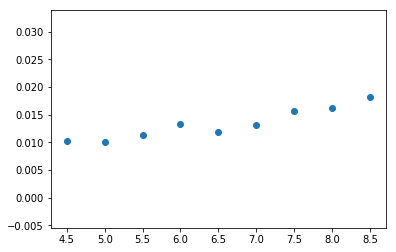

In [197]:
np.random.seed(42)

R = 470
U = np.arange(4.5, 9, 0.5)

I = (U + np.random.normal(0, 0.1, size=U.shape)) / R 
I = I + np.random.normal(0, 1e-3, size=I.shape)

_ = plt.scatter(U, I)

Показания пляшут. Однако, при помощи регрессии можно увеличить точность оценки сопротивления резистора. Сначала решим задачу линейной регрессии при помощи `LinearRegression` из библиотеки `scikit-learn`. Параметр `fit_intercept` указывает на то, что модель имеет свободный член $\theta_0$. Однако, мы знаем природу зависимости и знаем, что свободного члена нет. Поэтому, передаём значение `False`:

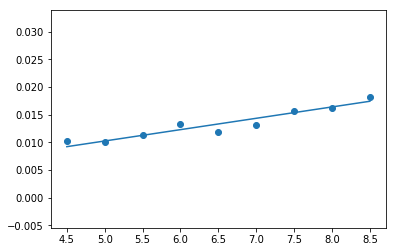

In [200]:
model = LinearRegression(fit_intercept=False)
model.fit(U[:, None], I)

xfit = np.linspace(U.min(), U.max())
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(U, I)
_ = plt.plot(xfit, yfit)

Теперь нам нужно достать информацию о сопротивлении. Модель выглядит как $y^*(x) = \theta_1x$, а реальная зависимость $I = \frac{U}{R}$. Значит, $R = \frac{1}{\theta}$. Коэффициенты модели хранятся в атрибуте `model.coef_`:

In [207]:
R = 1 / model.coef_[0]
print(f'Оценка сопротивления: {R:.4} Ом')

Оценка сопротивления: 487.3 Ом


А теперь прикоснёмся к реальным данным. Есть небольшой датасет, содержащий набор данных о систолическом артериальном давлении в зависимости от возраста.

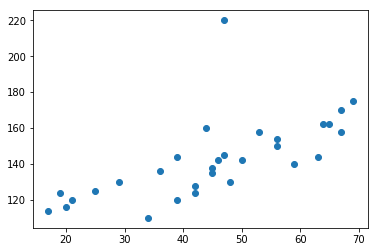

In [209]:
df = pd.read_csv('data/blood_pressure.csv')
_ = plt.scatter(df.age, df.pressure)


А теперь представим, что в результате какой-то технологической катастрофы человечество потеряло данные о том, каким должно быть систолическое артериальное давление у людей в возрасте от 30 до 50 лет. Попробуем восстановить их при помощи регрессии:

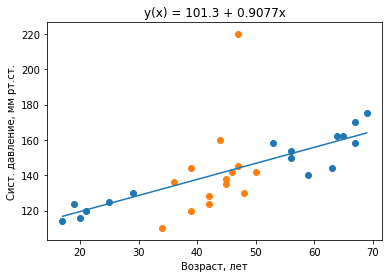

In [210]:
model = LinearRegression(fit_intercept=True)

df = pd.read_csv('data/blood_pressure.csv')

x = df[~df.age.between(30, 50)].age
y = df[~df.age.between(30, 50)].pressure

model.fit(x[:, None], y)

xfit = np.linspace(x.min(), x.max())
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.scatter(df[df.age.between(30, 50)].age, df[df.age.between(30, 50)].pressure)
plt.plot(xfit, yfit)

plt.xlabel('Возраст, лет')
plt.ylabel('Сист. давление, мм рт.ст.')

_ = plt.title(f'y(x) = {model.intercept_:4.4} + {model.coef_[0]:2.4}x')

Таким образом мы можем увидеть, во-первых, выбросы, во-вторых, узнать, какое давление должно быть у людей от 30 до 50 лет, и что давление поднимается примерно на 1 мм. рт.ст. в год.

Повторим то же самое на полном наборе данных чтобы убедиться, что мы хорошо аппроксимировали данные даже отбросив часть из них:

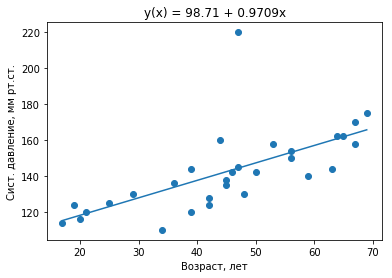

In [212]:
model = LinearRegression(fit_intercept=True)

df = pd.read_csv('data/blood_pressure.csv')

x = df.age
y = df.pressure

model.fit(x[:, None], y)

xfit = np.linspace(x.min(), x.max())
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)

plt.xlabel('Возраст, лет')
plt.ylabel('Сист. давление, мм рт.ст.')

_ = plt.title(f'y(x) = {model.intercept_:4.4} + {model.coef_[0]:2.4}x')